In [1]:
import os

import keras
import numpy as np
import pandas as pd
# from keras.saving import load_model
from bayesflow.adapters import Adapter

# ---------------- Configuration ----------------
PARAM_NAMES = ['v_base', 'a_init', 't_nd', 'leak', 'collapse_rate', 'gamma', 'sigma_cpp', 'sigma_n200']
CHECKPOINT_PATH = './checkpoints_unified_joint/unified_joint_model_final2.keras'
REAL_DATA_CSV = r'D:\python\mtcode\data1EA\behaviour_eeg_ea\sub02_eeg_behavioral_features.csv'

# ---------------- Load and Prepare Real Data ----------------
df = pd.read_csv(REAL_DATA_CSV)
summary_vars = df[['RT', 'Choice_Correct', 'CPP_Slope', 'N200_Latency']].to_numpy(dtype=np.float32)
summary_vars = summary_vars[~np.isnan(summary_vars).any(axis=1)]
summary_vars = summary_vars.reshape(1, *summary_vars.shape)  # [1, n_trials, n_features]

# ---------------- Rebuild Adapter ----------------
adapter = Adapter() \
    .to_array() \
    .convert_dtype('float64', 'float32') \
    .concatenate(['behavioral_data', 'eeg_data'], into='summary_variables', axis=-1) \
    .concatenate(PARAM_NAMES, into='inference_variables', axis=-1) \
    .standardize('summary_variables') \
    .keep(['summary_variables', 'inference_variables'])

# Adapt real data (simulate what would happen in the workflow)
# conditions = adapter({'summary_variables': summary_vars})

# ---------------- Load Trained Amortizer ----------------
approximator = keras.saving.load_model(CHECKPOINT_PATH)




INFO:bayesflow:Using backend 'tensorflow'
D:\myanaconda\envs\TORCHGPU3\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 397 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
import os
print(os.getcwd())

D:\python\mtcode\otherscode1NDDMChange\Single-trial-Integrative-N200\Model1a


In [2]:
# %% Joint Modeling of EEG and Behavioral Data - Unified Model for Two Datasets

import os
import numpy as np
import keras
from bayesflow.simulators import make_simulator
from bayesflow.adapters import Adapter
from bayesflow.networks import DeepSet, CouplingFlow
from bayesflow.workflows import BasicWorkflow
from pyddm import Model, ICPoint
from pyddm.models import Drift, Noise, Bound, Overlay
from pyddm.models.overlay import OverlayNonDecision

# %% Global Configuration
PARAM_NAMES = ['v_base', 'a_init', 't_nd', 'leak', 'collapse_rate', 'gamma', 'sigma_cpp', 'sigma_n200']
N_PARAMS = len(PARAM_NAMES)
N_TRIALS = 200
DT = 0.01
T_DUR = 5.0
NOISE_CONST = 1.0
FIXED_Z = 0.5
# Unified priors based on ACTUAL data statistics from both datasets
# PRIOR_LOWER_original = np.array([-3.0, 0.8, 0.3, 0.1, 0.0, 0.0, 0, 3, 0.01])
# PRIOR_UPPER_original = np.array([3.0, 2.5, 0.7, 0.4, 1.5, 0.8, 3.0, 7, 0.04])
#                      [v_base, a_init, z, t_nd, leak, collapse, gamma, sigma_cpp, sigma_n200]

PRIOR_LOWER = np.array([-3.0, 0.7, 0.25, 0.0, 0.0, -2.0, 3, 0.01])
PRIOR_UPPER = np.array([3.0, 2.0, 0.45, 2.0, 1.0, 2.0, 7, 0.04])

CHECKPOINT_DIR = './checkpoints_unified_joint'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Fixed rho parameter (instant ratio for N200-NDT relationship)
RHO = 1  # Direct 1:1 relationship


# %% Prior Function

def prior():
    """Generate unified prior samples for both datasets"""
    theta = np.random.uniform(PRIOR_LOWER, PRIOR_UPPER).astype(np.float32)
    return dict(zip(PARAM_NAMES, theta))


# %% Custom DDM Components

class DriftLeaky(Drift):
    name = "Leaky Drift"
    required_parameters = ["v_base", "leak"]

    def get_drift(self, x, t, conditions, **kwargs):
        return np.clip(self.v_base - self.leak * x, -8.0, 8.0)


class BoundExpCollapse(Bound):
    name = "Exponential Collapse"
    required_parameters = ["a_init", "collapse_rate"]

    def get_bound(self, t, conditions, **kwargs):
        return np.clip(self.a_init * np.exp(-self.collapse_rate * t), 0.01, 3.0)


class NoiseFixed(Noise):
    name = "Fixed Noise"
    required_parameters = ["noise"]

    def get_noise(self, x, t, conditions, **kwargs):
        return self.noise


# %% Behavioral Data Processing

def fixed_behavioral_data(sol, sample, n):
    """Extract and standardize behavioral data from PyDDM solution"""
    rt_up = np.array(sample.choice_upper)
    rt_lo = np.array(sample.choice_lower)
    rt = np.concatenate([rt_up, rt_lo])
    choice = np.concatenate([np.ones(len(rt_up)), np.zeros(len(rt_lo))])
    total = len(rt)

    # Ensure we have exactly n trials
    while total < n:
        additional_sample = sol.sample(n - total)
        rt_add_up = np.array(additional_sample.choice_upper)
        rt_add_lo = np.array(additional_sample.choice_lower)
        rt_add = np.concatenate([rt_add_up, rt_add_lo])
        choice_add = np.concatenate([np.ones(len(rt_add_up)), np.zeros(len(rt_add_lo))])
        rt = np.concatenate([rt, rt_add])
        choice = np.concatenate([choice, choice_add])
        total = len(rt)

    rt = rt[:n]
    choice = choice[:n]
    return np.stack([rt, choice], axis=1).astype(np.float32)


# %% Enhanced EEG Signal Generation

def simulate_decision_trajectories(v_base, leak, a_init, collapse_rate, t_nd, n_trials, n_timepoints=200, z=0.5):
    """Simulate decision trajectories with RT truncated at 5s"""
    timepoints = np.linspace(0, 5.0, n_timepoints)  # Max RT = 5s
    trajectories = np.zeros((n_trials, n_timepoints))

    v_trial = np.random.normal(v_base, 0.3, size=n_trials)
    leak_trial = np.ones(n_trials) * leak
    collapse_trial = np.ones(n_trials) * collapse_rate

    start_points = (z - 0.5) * a_init * 2
    current_pos = np.ones(n_trials) * start_points

    for t_idx, t in enumerate(timepoints):
        if t_idx == 0:
            trajectories[:, t_idx] = current_pos
            continue

        current_bound = a_init * np.exp(-collapse_trial * t)
        drift = v_trial - leak_trial * current_pos
        noise = np.random.normal(0, NOISE_CONST * np.sqrt(5.0 / n_timepoints), size=n_trials)  # Adjusted for 5s

        current_pos += drift * (5.0 / n_timepoints) + noise
        current_pos = np.clip(current_pos, -current_bound, current_bound)
        trajectories[:, t_idx] = current_pos

    return trajectories



def generate_realistic_eeg_features(trajectories, v_base, a_init, t_nd, leak, gamma, sigma_cpp, sigma_n200, n_trials):

    alpha = 0.25  # maximum latency ceiling
    beta = 6.0    # nonlinearity strength (adjust as needed)
    lat_n200 = np.clip(alpha * (1 - np.exp(-beta * t_nd)) + np.random.normal(0, abs(sigma_n200), size=n_trials), 0.15, 0.35)

    # -------------------------
    # CPP Slope: Clean and recoverable
    # -------------------------
    T = trajectories.shape[1]
    N = 5  # window size for averaging

    # Average late-phase and midpoint segments
    late_avg = trajectories[:, -N:].mean(axis=1)
    mid_avg = trajectories[:, (T//2 - N):(T//2)].mean(axis=1)
    delta_acc = np.abs(late_avg - mid_avg)

    # Log-normal noise
    xi = np.random.lognormal(mean=0, sigma=sigma_cpp, size=n_trials)

    # CPP slope
    slope_cpp = gamma * delta_acc * xi
    slope_cpp = np.clip(slope_cpp, -5.0, 5.0)

    return lat_n200, slope_cpp



# %% Likelihood Function - Unified for Both Datasets

def likelihood(v_base, a_init, t_nd, leak, collapse_rate, gamma, sigma_cpp, sigma_n200, n_trials=N_TRIALS):
    """Unified likelihood function for both datasets"""

    # Behavioral modeling with PyDDM
    try:
        model = Model(
            drift=DriftLeaky(v_base=v_base, leak=leak),
            noise=NoiseFixed(noise=NOISE_CONST),
            bound=BoundExpCollapse(a_init=a_init, collapse_rate=collapse_rate),
            overlay=OverlayNonDecision(nondectime=t_nd),
            dx=0.01, dt=DT, T_dur=T_DUR
        )

        sol = model.solve()
        samp = sol.sample(n_trials)
        behav = fixed_behavioral_data(sol, samp, n_trials)

    except:
        # Fallback with realistic RT range matching both datasets
        # Dataset A: mean=0.76s, Dataset B: mean=1.35s
        rt = np.random.uniform(0.2, 5.0, n_trials)  # Conservative upper bound

        # Choice proportion between datasets (A: 50.4%, B: 96.4%)
        choice_prob = np.random.uniform(0.5, 0.95)  # Variable choice bias
        choice = np.random.binomial(1, choice_prob, n_trials)
        behav = np.stack([rt, choice], axis=1).astype(np.float32)

    # Generate decision trajectories
    trajectories = simulate_decision_trajectories(
        v_base, leak, a_init, collapse_rate, t_nd, n_trials, z=0.5
    )

    # Generate realistic EEG features
    lat_n200, slope_cpp = generate_realistic_eeg_features(
        trajectories, v_base, a_init, t_nd, leak, gamma, sigma_cpp, sigma_n200, n_trials
    )

    eeg = np.stack([lat_n200, slope_cpp], axis=1).astype(np.float32)

    # Quality checks with realistic fallbacks
    if not np.all(np.isfinite(behav)) or not np.all(np.isfinite(eeg)):
        # Realistic fallback matching EXACT data distributions
        rt = np.random.uniform(0.5, 5.0, n_trials)
        choice = np.random.binomial(1, 0.75, n_trials)  # Between 50.4% and 96.4%
        behav = np.stack([rt, choice], axis=1).astype(np.float32)

        # EEG fallback matching EXACT observed ranges and distributions
        n200 = np.random.normal(0.21, 0.03, n_trials)  # Mean between datasets
        n200 = np.clip(n200, 0.15, 0.30)

        cpp = np.random.normal(-0.7, 4.9, n_trials)  # Negative mean, wide SD
        cpp = np.clip(cpp, -10.0, 10.0)
        eeg = np.stack([n200, cpp], axis=1).astype(np.float32)

    return {'behavioral_data': behav, 'eeg_data': eeg}


# %% Simulator
simulator = make_simulator([prior, likelihood])

# %% Adapter
adapter = Adapter() \
    .to_array() \
    .convert_dtype('float64', 'float32') \
    .concatenate(['behavioral_data', 'eeg_data'], into='summary_variables', axis=-1) \
    .concatenate(PARAM_NAMES, into='inference_variables', axis=-1) \
    .standardize('summary_variables') \
    .keep(['summary_variables', 'inference_variables'])

# %% Networks - Optimized for unified modeling
summary_net = DeepSet(summary_dim=128, num_layers=4)
inference_net = CouplingFlow(
    depth=10,
    input_dim=N_PARAMS,
    subnet='mlp',
    subnet_kwargs={'hidden_units': [128, 128, 64], 'activation': 'elu'},
    permutation='random',
    use_actnorm=True,
    base_distribution='normal'
)

# %% Workflow
workflow = BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    summary_network=summary_net,
    inference_network=inference_net,
    checkpoint_filepath=CHECKPOINT_DIR,
    checkpoint_name="unified_joint_model"
)


# %% Training Functions

def train_unified_model(epochs=2, simulations_per_epoch=10000, learning_rate=5e-5, batch_size=32):
    """Train unified model for both datasets"""

    print("=== Training Unified Joint EEG-Behavioral Model ===")
    print(f"Parameters: epochs={epochs}, lr={learning_rate}, batch_size={batch_size}")
    print("Unified model features:")
    print(f"  • Fixed ρ = {RHO} for N200-NDT relationship")
    print("  • Negative CPP slopes allowed (matching real data)")
    print("  • Wide parameter ranges covering both datasets")
    print("  • N200 range: 0.15-0.30s, CPP range: -10 to +10")
    print("Prior ranges:")
    for i, param in enumerate(PARAM_NAMES):
        print(f"  {param:>12}: [{PRIOR_LOWER[i]:>6.3f}, {PRIOR_UPPER[i]:>6.3f}]")
    print()

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    history = workflow.fit_online(
        epochs=epochs,
        simulations_per_epoch=simulations_per_epoch,
        batch_size=batch_size,
        optimizer=optimizer,
        show_progress=True
    )

    save_path = f"{CHECKPOINT_DIR}/unified_joint_model.keras"
    workflow.approximator.save(filepath=save_path, overwrite=True)
    print(f"Unified model saved to {save_path}")

    return history


def run_parameter_recovery(n_recovery=500):
    """Run parameter recovery analysis"""
    print(f"\nRunning Parameter Recovery Analysis...")
    print("=" * 50)

    # Generate recovery data
    recovery_data = workflow.simulator.sample(batch_size=n_recovery)
    adapted = workflow.adapter(recovery_data)

    # Filter valid data
    valid_mask = ~np.isnan(adapted['summary_variables']).any(axis=1)
    valid_idx = np.where(valid_mask)[0]

    if len(valid_idx) == 0:
        print("No valid simulations for parameter recovery!")
        return

    print(f"Valid simulations: {len(valid_idx)}/{n_recovery}")

    true_params = adapted['inference_variables'][valid_idx]
    conditions = {k: v[valid_idx] for k, v in recovery_data.items() if k not in PARAM_NAMES}

    # Sample posteriors
    posteriors = workflow.sample(conditions=conditions, num_samples=1000)
    posterior_array = np.stack([posteriors[k] for k in PARAM_NAMES], axis=-1)

    if posterior_array.ndim == 4 and posterior_array.shape[2] == 1:
        posterior_array = np.squeeze(posterior_array, axis=2)

    # Calculate recovery metrics
    estimates_mean = posterior_array.mean(axis=1)

    print("\nParameter Recovery Results:")
    print("=" * 50)

    recovery_metrics = {}
    for i, name in enumerate(PARAM_NAMES):
        true_vals = true_params[:, i]
        est_vals = estimates_mean[:, i]

        # Correlation
        r = np.corrcoef(true_vals, est_vals)[0, 1] if np.std(true_vals) > 0 else 0.0

        # Bias and RMSE
        bias = np.mean(est_vals - true_vals)
        rmse = np.sqrt(np.mean((est_vals - true_vals) ** 2))

        recovery_metrics[name] = {'correlation': r, 'bias': bias, 'rmse': rmse}

        print(f"{name:>15}: r = {r:>6.3f}, bias = {bias:>7.4f}, RMSE = {rmse:>6.3f}")

    # Create recovery plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()

    for i, name in enumerate(PARAM_NAMES):
        ax = axes[i]
        true_vals = true_params[:, i]
        est_vals = estimates_mean[:, i]

        ax.scatter(true_vals, est_vals, alpha=0.6, s=20)

        # Perfect recovery line
        min_val, max_val = true_vals.min(), true_vals.max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

        ax.set_xlabel(f'True {name}')
        ax.set_ylabel(f'Estimated {name}')
        ax.set_title(f'{name} (r = {recovery_metrics[name]["correlation"]:.3f})')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Unified Model Parameter Recovery', fontsize=16, y=0.98)
    plt.show()

    return posteriors, true_params, recovery_metrics


# %% Data Distribution Analysis

def analyze_simulated_distributions(n_samples=1000):
    """Analyze simulated data distributions vs real data"""
    print("\nAnalyzing Simulated Data Distributions...")
    print("=" * 50)

    # Generate sample data
    sample_data = workflow.simulator.sample(batch_size=n_samples)

    # Extract data
    behav_data = sample_data['behavioral_data']
    eeg_data = sample_data['eeg_data']

    rt_sim = behav_data[:, :, 0].flatten()
    choice_sim = behav_data[:, :, 1].flatten()
    n200_sim = eeg_data[:, :, 0].flatten()
    cpp_sim = eeg_data[:, :, 1].flatten()

    print("SIMULATED DATA STATISTICS (should match real data):")
    print(f"RT: Mean={rt_sim.mean():.3f}s, SD={rt_sim.std():.3f}")
    print(f"RT: Min={rt_sim.min():.3f}, Max={rt_sim.max():.3f}")
    print(f"RT: Target ranges - A: 0.76±0.19s, B: 1.35±0.81s")
    print(f"Choice proportion: {choice_sim.mean():.3f} (target: 0.50-0.96)")
    print(f"N200: Mean={n200_sim.mean():.3f}s, SD={n200_sim.std():.4f}")
    print(f"N200: Min={n200_sim.min():.3f}, Max={n200_sim.max():.3f}")
    print(f"N200: Target - A: 0.191±0.023s, B: 0.228±0.040s")
    print(f"CPP: Mean={cpp_sim.mean():.3f}, SD={cpp_sim.std():.3f}")
    print(f"CPP: Min={cpp_sim.min():.3f}, Max={cpp_sim.max():.3f}")
    print(f"CPP: % negative = {(cpp_sim < 0).mean() * 100:.1f}% (target: 51-60%)")
    print(f"CPP: Target - A: -0.225±4.97, B: -1.086±4.80")


Running parameter recovery analysis with 200 simulations...
Found 200 valid simulations out of 200.


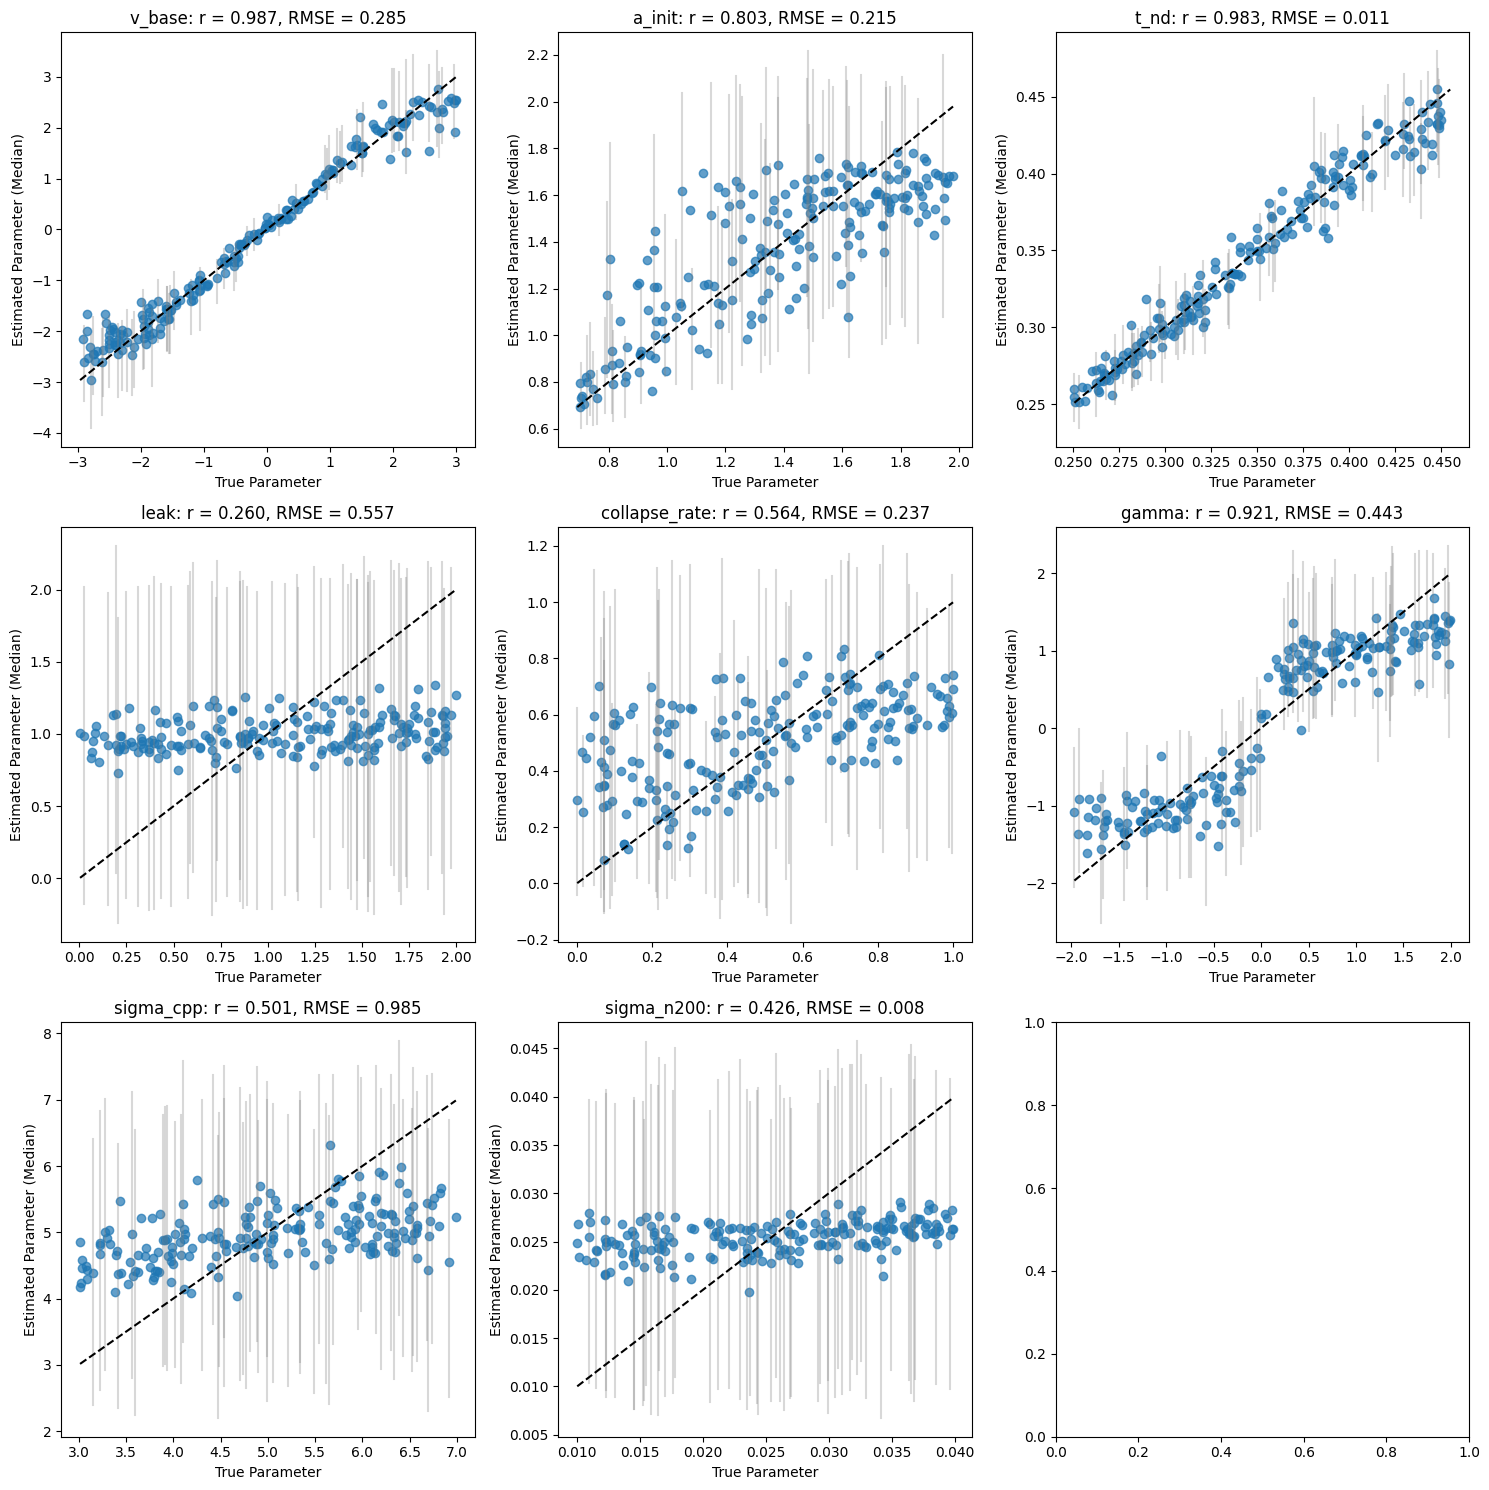


Parameter Recovery Metrics:
Parameter         r (Mean) r (Median)  RMSE (Mean) RMSE (Median) Calib. Err
---------------------------------------------------------------------------
v_base               0.988      0.987        0.277        0.285      0.082
a_init               0.803      0.803        0.215        0.215      0.020
t_nd                 0.982      0.983        0.011        0.011      0.076
leak                 0.256      0.260        0.558        0.557      0.088
collapse_rate        0.564      0.564        0.236        0.237      0.034
gamma                0.921      0.921        0.442        0.443      0.025
sigma_cpp            0.504      0.501        0.983        0.985      0.043
sigma_n200           0.430      0.426        0.008        0.008      0.079

Overall Recovery Performance:
Average correlation (r): 0.681
Average RMSE: 0.343
Average calibration error: 0.056


In [3]:
from run_parameter_recovery_analysis import *
metrics = run_parameter_recovery_analysis(
    approximator=approximator,
    simulator=simulator,
    adapter=adapter,
    param_names=PARAM_NAMES,
    n_sims=200  # or more
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data
np.random.seed(0)
n_points = 50
time = np.linspace(0, 1, n_points)
trajectory = np.cumsum(np.random.randn(n_points))  # cumulative evidence
trajectory = (trajectory - np.min(trajectory)) / (np.max(trajectory) - np.min(trajectory)) * 1.5 - 0.2  # scale

# Midpoint and endpoint index
half_idx = n_points // 2
window_size = 5

# Define window indices
window_mid = np.arange(half_idx - window_size//2, half_idx + window_size//2)
window_end = np.arange(n_points - window_size, n_points)

# Compute averages in each window
avg_mid = np.mean(trajectory[window_mid])
avg_end = np.mean(trajectory[window_end])

# Compute Δ_acc
delta_acc = avg_end - avg_mid


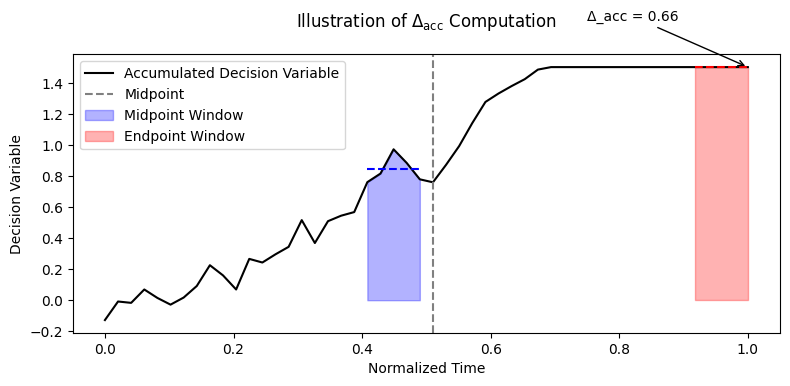

In [10]:
# Plot
plt.figure(figsize=(8, 4))
plt.plot(time, trajectory, label='Accumulated Decision Variable', color='black')
plt.axvline(x=time[half_idx], color='gray', linestyle='--', label='Midpoint')

# Highlight averaging windows
plt.fill_between(time[window_mid], trajectory[window_mid], alpha=0.3, color='blue', label='Midpoint Window')
plt.fill_between(time[window_end], trajectory[window_end], alpha=0.3, color='red', label='Endpoint Window')

# Annotate averages
plt.hlines(avg_mid, time[window_mid[0]], time[window_mid[-1]], color='blue', linestyle='--')
plt.hlines(avg_end, time[window_end[0]], time[window_end[-1]], color='red', linestyle='--')

# Adjust annotation position
plt.annotate(f'Δ_acc = {delta_acc:.2f}',
             xy=(time[-1], avg_end),
             xytext=(time[-1] - 0.25, avg_end + 0.3),  # moved up and left
             arrowprops=dict(arrowstyle='->'),
             fontsize=10)

# Adjust title vertical position
plt.title('Illustration of $\Delta_{\\text{acc}}$ Computation', pad=20)  # increased padding

plt.xlabel('Normalized Time')
plt.ylabel('Decision Variable')
plt.legend()
plt.tight_layout()


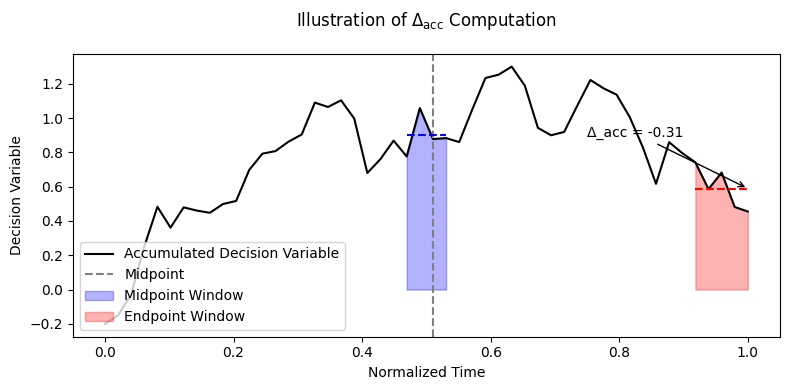

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data
np.random.seed(0)
n_points = 50
time = np.linspace(0, 1, n_points)
trajectory = np.cumsum(np.random.randn(n_points))  # cumulative evidence
trajectory = (trajectory - np.min(trajectory)) / (np.max(trajectory) - np.min(trajectory)) * 1.5 - 0.2  # scale

# Midpoint and endpoint index
half_idx = n_points // 2
window_size = 5

# Define window indices
window_mid = np.arange(half_idx - window_size//2, half_idx + window_size//2)
window_end = np.arange(n_points - window_size, n_points)

# Compute averages in each window
avg_mid = np.mean(trajectory[window_mid])
avg_end = np.mean(trajectory[window_end])

# Compute Δ_acc
delta_acc = avg_end - avg_mid


In [2]:
from analyze_multiple_subjects import analyze_multiple_subjects

PARAM_NAMES = ['v_base', 'a_init', 't_nd', 'leak', 'collapse_rate', 'gamma', 'sigma_cpp', 'sigma_n200']

analyze_multiple_subjects(
    data_dir=r'D:\python\mtcode\data1EA\behaviour_eeg_ea',
    model_path='./checkpoints_unified_joint/unified_joint_model_final2.keras',
    param_names=PARAM_NAMES,
    output_dir='./group_results_data1'
)


Found 22 subject/condition files
Loading model from ./checkpoints_unified_joint/unified_joint_model_final2.keras


D:\myanaconda\envs\TORCHGPU3\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 397 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Processing sub02...
  Using 335 valid trials for inference

Processing sub03...
  Using 223 valid trials for inference

Processing sub04...
  Using 329 valid trials for inference

Processing sub05...
  Using 213 valid trials for inference

Processing sub06...
  Using 252 valid trials for inference

Processing sub07...
  Using 224 valid trials for inference

Processing sub08...
  Using 288 valid trials for inference

Processing sub10...
  Using 260 valid trials for inference

Processing sub11...
  Using 328 valid trials for inference

Processing sub12...
  Using 228 valid trials for inference

Processing sub13...
  Using 268 valid trials for inference

Processing sub14...
  Using 206 valid trials for inference

Processing sub15...
  Using 232 valid trials for inference

Processing sub16...
  Using 361 valid trials for inference

Processing sub18...
  Using 305 valid trials for inference

Processing sub19...
  Using 245 valid trials for inference

Processing sub20...
  Using 242 valid t

(    Subject      Parameter      Mean    Median       Std   HDI_Low  HDI_High
 0     sub02         v_base -0.076556 -0.074627  0.178914 -0.399268  0.291690
 1     sub02         a_init  1.548838  1.561403  0.261227  1.018082  2.019710
 2     sub02           t_nd  0.282973  0.283251  0.011305  0.262217  0.306602
 3     sub02           leak  1.080020  1.081139  0.562457  0.042881  2.231037
 4     sub02  collapse_rate  0.269398  0.264104  0.165090 -0.049789  0.593931
 ..      ...            ...       ...       ...       ...       ...       ...
 171   sub25           leak  1.052002  1.089238  0.541251  0.013768  2.069339
 172   sub25  collapse_rate  0.270611  0.270870  0.173369 -0.073206  0.618399
 173   sub25          gamma  0.726530  0.738416  0.516651 -0.185991  1.814758
 174   sub25      sigma_cpp  5.267749  5.269200  1.047754  3.145211  7.295167
 175   sub25     sigma_n200  0.031820  0.031410  0.008972  0.013800  0.048887
 
 [176 rows x 7 columns],
 {'sub02': array([[-0.17151755,  1.33

In [1]:
from analyze_multiple_subjects2 import analyze_multiple_subjects

PARAM_NAMES = ['v_base', 'a_init', 't_nd', 'leak', 'collapse_rate', 'gamma', 'sigma_cpp', 'sigma_n200']

analyze_multiple_subjects(
    data_dir=r'D:\python\mtcode\data2features_combined',
    model_path='./checkpoints_unified_joint/unified_joint_model_final2.keras',
    param_names=PARAM_NAMES,
    output_dir='./group_results_data2'
)


INFO:bayesflow:Using backend 'tensorflow'


Found 41 subject/condition files
Loading model from ./checkpoints_unified_joint/unified_joint_model_final2.keras


D:\myanaconda\envs\TORCHGPU3\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 397 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



Processing sub-01...
  Using 162 valid trials for inference

Processing sub-02...
  Using 164 valid trials for inference

Processing sub-02...
  Using 175 valid trials for inference

Processing sub-03...
  Using 210 valid trials for inference

Processing sub-04...
  Using 198 valid trials for inference

Processing sub-04...
  Using 186 valid trials for inference

Processing sub-06...
  Using 172 valid trials for inference

Processing sub-07...
  Using 226 valid trials for inference

Processing sub-07...
  Using 249 valid trials for inference

Processing sub-08...
  Using 185 valid trials for inference

Processing sub-09...
  Using 206 valid trials for inference

Processing sub-09...
  Using 213 valid trials for inference

Processing sub-10...
  Using 162 valid trials for inference

Processing sub-11...
  Using 190 valid trials for inference

Processing sub-11...
  Using 220 valid trials for inference

Processing sub-13...
  Using 176 valid trials for inference

Processing sub-13...
  

(    Subject      Parameter      Mean    Median       Std   HDI_Low  HDI_High
 0    sub-01         v_base -0.079782 -0.082550  0.181199 -0.443124  0.278410
 1    sub-01         a_init  1.538916  1.546727  0.259757  1.023832  2.028965
 2    sub-01           t_nd  0.281728  0.281997  0.010378  0.262323  0.302292
 3    sub-01           leak  1.086648  1.104031  0.534990 -0.046799  2.073750
 4    sub-01  collapse_rate  0.265403  0.258746  0.172605 -0.096585  0.576209
 ..      ...            ...       ...       ...       ...       ...       ...
 323  sub-31           leak  0.965584  0.960540  0.572896 -0.140306  2.107749
 324  sub-31  collapse_rate  0.280589  0.275955  0.180293 -0.049166  0.631390
 325  sub-31          gamma  0.779390  0.758758  0.529049 -0.256991  1.784734
 326  sub-31      sigma_cpp  5.576909  5.577727  1.042588  3.289289  7.385754
 327  sub-31     sigma_n200  0.035422  0.035185  0.009650  0.016128  0.054378
 
 [328 rows x 7 columns],
 {'sub-01': array([[-2.69875765e-01, 